# Parametric Inference &mdash; part 1

In this notebook using a library, `statsmodels` for statistical tests and analysis

## Roadmap
* [Sampling distributions and normal approximation](#Sampling-distributions-and-normal-approximation)
* [Confidence intervals with Z distribution](#Confidence-intervals-with-Z-distribution)
    * [Confidence interval for proportion](#Confidence-interval-for-proportion)
    * [Confidence interval for the mean](#Confidence-interval-for-the-mean)
    * [Correct intepretation of CIs](#Correct-interpretation-of-CIs)
* [Hypothesis testing for one-sample mean](#Hypothesis-testing-for-one-sample-mean)
* [Binomial test](#Binomial-test)
    * [Binomial confidence intervals](#Binomial-confidence-intervals)


## Sampling distributions and normal approximation
* CLT provides a good (and theoretically sound) approximation of the sampling distribution of the sample mean (or sum)
* Here is the comparison of the CLT distribution with the empirical sampling distribution of the mean for the (continuous) uniform distribution
    * consider the uniform distribution over the interval [0,10], denoted $\mathcal{U}(0,10)$
    * the default uniform RV object is over [0,1], but can be modified using `loc` and `scale` parameters into [`loc`,`loc`+`scale`]

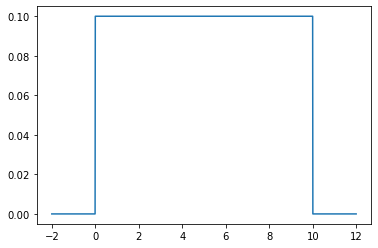

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# consider a uniform distribution with endpoints 0 and 10
my_unif = stats.uniform(loc=0, scale=10)

# plotting the pdf
x = np.arange(-2,12,0.01)
plt.plot(x, my_unif.pdf(x))
plt.show()

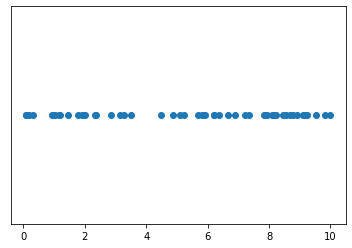

In [2]:
# Drawing 1000 uniform samples, each of size 50
sample_num = 1000
sample_size = 50

# initializing a numpy array of size (sample_num, sample_size) to store the samples
samples = np.empty([sample_num, sample_size])

# Drawing the samples by calling the rvs function
for i in range(sample_num):
    samples[i,:] = my_unif.rvs(size=sample_size)
    
# plotting one of the samples (say the 111-th) using a dotplot
plt.scatter(samples[110,:], np.zeros(sample_size))
ax = plt.gca()
ax.get_yaxis().set_visible(False)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


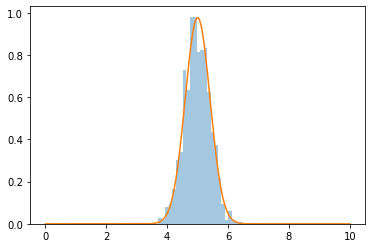

In [3]:
# Computing the sample means for the samples
means = np.mean(samples, axis=1) # row-wise

# computing the normal approximation of the sampling distribution as per the CLT
# the mean of the normal approx. is the mean of U(0,10) (which is 5), 
#     and its standard deviation is given by the SE of the mean 
#     (i.e., the standard deviation of U(0,10) over sqrt of n)
SE = my_unif.std()/np.sqrt(sample_size)
normal_approx = stats.norm(loc=my_unif.mean(), scale=SE)

# plotting frequency histogram of the empirical sampling distribution (i.e., the distribution of 'means')
#     and overlay normal approximation
sns.distplot(means, kde=False, norm_hist=True)
x = np.arange(0,10,0.001)
sns.lineplot(x, normal_approx.pdf(x))
plt.show()

## Confidence intervals with Z distribution

### Confidence interval for proportion
* Compute a Z confidence interval for a proportion manually, i.e., by using the sample proportion and the CI halfwidths computed via the inverse cdf (aka ppf) of the Z distribution (standard normal).
* For significance $\alpha \in (0,1)$, the $(1-\alpha)$-CI for a proportion (using the normal approximation) is given by $$\left[\hat{p}\pm z_{\alpha/2}\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}\right]$$
where $z_{\alpha/2}$ is the critical value at level $\alpha/2$, i.e., such that $P(X\geq z_{\alpha/2})=\alpha/2$ for $X\sim \mathcal{N}(0,1)$, i.e., $z_{\alpha/2}$ is the value of the inverse CDF at probability $1-\alpha/2$


Here the dataset of murder statistics in the greater London area (available [here](https://www.openintro.org/stat/data.php?data=london_murders)) is used. The dataset contains the victim name, age, and location of every murder recorded in the Greater London area by the Metropolitan Police from January 1, 2006 to September 7, 2011. 

Variables are:
* forename - First name(s) of the victim.
* age - Age of the victim.
* date - Date of the murder (YYYY-MM-DD).
* year - Year of the murder.
* borough - The London borough in which the murder took place. 

In [4]:
import numpy as np
import pandas as pd
from scipy import stats

# reading the csv file and store it into pd dataframe
df_murders = pd.read_csv("london_murders.csv")

# Head function to see a preview of the top-most rows
df_murders.head()

,forename,age,date,year,borough
0,Barrington Derrick,19,2006-01-02,2006,Hackney
1,Aaron,24,2006-01-02,2006,Lewisham
2,Christopher,22,2006-01-03,2006,Hillingdon
3,Thomas Philip,18,2006-01-04,2006,Camden
4,Amanda,26,2006-01-04,2006,Camden


computing a CI (with normal approx.) for the probability of a victim being younger than 18 for a random sample of 100 observations

In [5]:
n = 100
# let's fix a value for alpha
alpha = 0.05

# drawing a random sample of size n
df_murders_sample = df_murders.sample(n)
# computing sample proportion of under 18
prop_below_18 = np.mean(df_murders_sample.age<18)
print('sample proportion is '+str(prop_below_18))

# standard error 
se_below_18 = np.sqrt(prop_below_18*(1-prop_below_18)/n)
# z_{alpha/2} via ppf of standard normal
z_val_below_18 = stats.norm.ppf(1-alpha/2)
# or equivalently
# z_val_below_18 = -stats.norm.ppf(alpha/2)
print('critical Z score is: '+str(z_val_below_18))

# computing and printing confidence interval
ci_below_18_approx = prop_below_18 + z_val_below_18*se_below_18*np.array([-1,1])
print('confidence interval is: '+str(ci_below_18_approx))

sample proportion is 0.1
critical Z score is: 1.959963984540054
confidence interval is: [0.04120108 0.15879892]


* Or, the confidence interval could have been computed "automatically" using the `statsmodels` package.
* The relevant function is called `proportion_confint` of the `stats` module of `statsmodels`. It takes in input: 
    * `count`, the number of successes ($n\hat{p}$)
    * `nobs`, the number of trials ($n$)
    * `alpha=0.05`, the significance level (default to 0.05) and 
    * `method='normal'`, the method used to compute the interval (default with normal approximation). Other methods are available, see https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_confint.html   

In [6]:
import statsmodels.api as sm
print(sm.stats.proportion_confint(
    count=n*prop_below_18, nobs=n, alpha=alpha))

(0.04120108046379837, 0.15879891953620165)


### Confidence interval for the mean
* Computing Z confidence interval for the mean
* The interval is given by $\left[\bar{x}_n \pm z_{\alpha/2} SE\right]$ where $\bar{x}_n$ is the sample mean and $SE=\sigma/\sqrt{n}$.
* When $n$ is large enough we can replace (unknown true) $\sigma$ with sample standard deviation $s$.
* Let's compute a CI for the mean age of a victim from our sample

In [7]:
# computing sample mean and standard error for the sample drawn above
mean_age = np.mean(df_murders_sample.age)
print('Sample mean of age is: '+str(mean_age))

# IMPORTANT: by default, the number of degrees of freedom in the sample variance are n, 
# not n-1. The ddof parameter tells us how many fewer dof we have (in our case n-1, so 1)
SE_age = np.std(df_murders_sample.age, ddof=1)/np.sqrt(n)

# computing the CI manually, using the ppf of the z distribution (similar to above)
ci_mean_age = mean_age + SE_age*stats.norm.ppf(1-alpha/2)*np.array([-1,1])
print('CI for age is: '+str(ci_mean_age))

Sample mean of age is: 32.53
CI for age is: [29.25728695 35.80271305]


Similarly for the proportion case, `statsmodels` provides an "automatic" method via function `zconfint` to compute the z-CI. It simply takes in input the sample and the level $\alpha$ (there are other parameters that we can ignore for now, see https://www.statsmodels.org/dev/generated/statsmodels.stats.weightstats.zconfint.html#statsmodels.stats.weightstats.zconfint)

In [8]:
print(sm.stats.zconfint(df_murders_sample.age, alpha=alpha))

(29.257286948600502, 35.8027130513995)


### Correct interpretation of CIs
* "$(1-\alpha)$ confidence" means that if we repeatedly built CIs for multiple random samples, then about $(1-\alpha)$ of the built CIs will contain the true parameter.
* Let's see this in action: generating random normal samples with known mean, computing a CI for each, and see how often the true parameter falls in the CI


In [9]:
n_samples = 1000 # number of samples
sample_size = 50 # sample size
# suppose the true (unknown) population distribution is a normal with mean 11 and stdev 3
mu = 11
sigma = 3
my_norm = stats.norm(loc=mu, scale=sigma)
alpha = 0.05
# variable to count how many times the true mu is inside the CI
param_inside_CI = 0
# for each sample
for i in range(n_samples): 
    # drawing the normal sample
    norm_sample = my_norm.rvs(sample_size)  
    # computing CI based on Z distribution (and plugging sample stdev instead of sigma)
    sample_mean = np.mean(norm_sample)
    std_err = np.std(norm_sample, ddof=1)/np.sqrt(sample_size)
    ci_mean = sample_mean + std_err*stats.norm.ppf(1-alpha/2)*np.array([-1,1])
    # or this could be done directly with statsmodels' automatic method
    # ci_mean = sm.stats.zconfint(norm_sample, alpha=alpha)
    
    # check if the true mu is inside the CI
    param_inside_CI+=(mu>=ci_mean[0] and mu<=ci_mean[1])

# It is expected to be close to 1-alpha = 0.95
print('Empirical confidence: '+ str(param_inside_CI/n_samples))

Empirical confidence: 0.945


## Hypothesis testing for one-sample mean

* Now HT for the mean age, using the Z-test
* Assume that previous studies found that the mean age of a victim in London is 30. So $H_0: \mu = 30$.
* We want to test whether our data is consistent with $H_0$ with a two-sided Z-test. So $H_a: \mu \neq 30$
    * I.e., if the observed mean is significantly higher or lower the null value
* Let's manually compute the test statistic ($\frac{\bar{x}_n-\mu_0}{(s/\sqrt{n})}$) and the p-value w.r.t. the sampling distribution under $H_0$ (z distribution $\mathcal{N}(0,1)$)


In [10]:
# test statistic
mu_0 = 30
# SE age was computed previously
z_val = (mean_age - mu_0)/SE_age
print('test statistic: '+str(z_val))
# distribution under H0
h0_dist = stats.norm

# computing p-value for two-sided test
left_p_val = h0_dist.cdf(z_val) # P(Z<=z_val)
right_p_val = 1-h0_dist.cdf(z_val) # P(Z>=z_val)
p_val = 2*np.min([left_p_val,right_p_val])
print('p value: '+str(p_val))

test statistic: 1.5151676309555657
p value: 0.12972995805883158


`statsmodels` provides an automated method to perform z tests. It takes in input:
* `x1`, the sample
* `value`, the null value
* `alternative='two-sided'`, the direction of the test (or, `alternative='larger'` for one-sided right-tailed, `alternative='smaller'` for one-sided left-tailed)
* (there are other parameters that we can ignore for now, see https://www.statsmodels.org/dev/generated/statsmodels.stats.weightstats.ztest.html#statsmodels.stats.weightstats.ztest).
It returns the value of the test statistic and the corresponding p value.

In [11]:
# or, alternative='larger' for one-sided right-tailed, alternative='smaller' for one-sided left-tailed
t_value, p_value = sm.stats.ztest(df_murders_sample.age, value=mu_0,alternative='two-sided')
print('test statistic: '+str(t_value))
print('p value: '+str(p_value))

test statistic: 1.515167630955566
p value: 0.12972995805883147


### Plotting sampling distribution and critical region
* The plots to show the sampling distribution and the critical regions for a test can be produced, by adapting the code we saw in the previous lab
* let's demonstrate it for a one-sided z-test

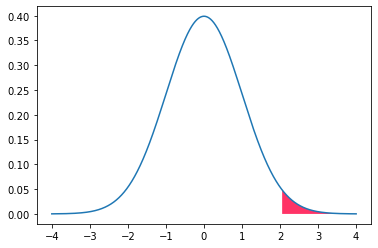

In [12]:


# values for which we compute the pdf of the sampling distribution
x = np.arange(-4, 4, 0.001)

# highlight the critical region for one-sided test at some level
alpha = 0.02
# sampling distribution under H_0
sampl_dist = stats.norm

# the critical value it z_alpha s.t. P(Z>=z_alpha)=alpha.
# so using the ppf
z_alpha = sampl_dist.ppf(1-alpha)
# or, z_alpha = -sampl_dist.ppf(alpha)

# selecting the points to fill using a Boolean condition.
# i.e., selecting the points corresponding to the critical region
highlight_cond = x >= z_alpha
# the result is a Boolean array

# first, plot the pdf for x
y = sampl_dist.pdf(x)
plt.plot(x, y)
# then, fill the area based on highlight_cond
plt.fill_between(x, 0, y, where=highlight_cond, facecolor='#ff3366')
plt.show()

## Binomial test
* The exact inference for proportions using the binomial test can be done. 
* $H_0: p=p_0$; $H_a: p \neq p_0$; statistic: $n\hat{p}$; sampl. distr.: $B(n,p_0)$
* It can be done "manually"!

In [13]:
# let's consider the previous example
prop_below_18 = np.mean(df_murders_sample.age<18)
print('sample proportion is '+str(prop_below_18))

# we want to do HT about the proportion of victims under 18
# assume H_0: p=0.3 and H_a: p<0.3

# the p-value is given by the probability of observing a more extreme test statistic,
# so a lower number of victims under 18 in our sample. 
# The probability is computed w.r.t. the H_0 distribution B(n,0.3)

p_val_bin = stats.binom(n,0.3).cdf(n*prop_below_18)
print('p value of binomial test is: '+str(p_val_bin))

sample proportion is 0.1
p value of binomial test is: 1.5555659316780433e-06


Or could be done using, `scipy.stats`'s `binom_test` function (or `statsmodels`'s `binom_test`). See below

In [14]:
# binom_test of scipy.stats takes in input the test statistic (number of successes), number of trials, and p_0
# alternative param is one of two-sided’, ‘greater’, ‘less’
p_val_bin = stats.binom_test(x=n*prop_below_18, n=n, p=0.3, alternative='less')
print('p value of binomial test is: '+str(p_val_bin))
# for the statsmodels version, see https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.binom_test.html

p value of binomial test is: 1.5555659316780433e-06


### Binomial confidence intervals
* For proportions, computing _precise_ intervals, that don't rely on normal approx.
* using the binomial distribution, noting that $n\hat{p}\sim B(n,p)$
    * However, we don't know $p$, and using $B(n,\hat{p})$ would be an approximation
* `statsmodels`'s `proportion_confint' function allows to select different methods from the normal, including the method based on inverting the Binomial test
    * Recall that we can construct a CI from a test by "collecting" all the $H_0$ values that are not rejected by the test
    * In our case, these are all the $p_0$ values such that $n\hat{p}$ falls in the acceptance region of $B(n,p_0)$

In [ ]:
# The function 'proportion_confint' takes in input:
# count, nobs, alpha=0.05, method
# by default, method is 'normal' (normal approx)
# here using 'binom_test' (for inversion of binomial test)
# see https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_confint.html
sm.stats.proportion_confint(
    count=n*prop_below_18, nobs=n, alpha=alpha, method='binom_test')